In [2]:
# Data Processing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# GeoProcessing
import geopandas as gpd
from shapely.geometry import Point

# ML Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
# from tensorflow.keras.layers import LSTM, Dense, Input, Reshape, Dropout # type: ignore

In [3]:
path_train = '1-Resources/Technical Assesments/Task 1/train_land_cover_assignment.csv'
path_test = '1-Resources/Technical Assesments/Task 1/test_land_cover_assignment.csv'
data_in = pd.read_csv(path_train)

## 1. EXPLORE DATASET

### 1a. Categorical Columns

In [4]:
# Extract Categorical Columns
cats = data_in.select_dtypes(include='object')
cats.head(5)

,building,cropland,wcover
0,No,No,>60%
1,No,Yes,<30%
2,No,Yes,<30%
3,No,No,<30%
4,No,No,<30%


In [5]:
# Check for Null values
cats.isna().sum()

building    0
cropland    0
wcover      0
dtype: int64

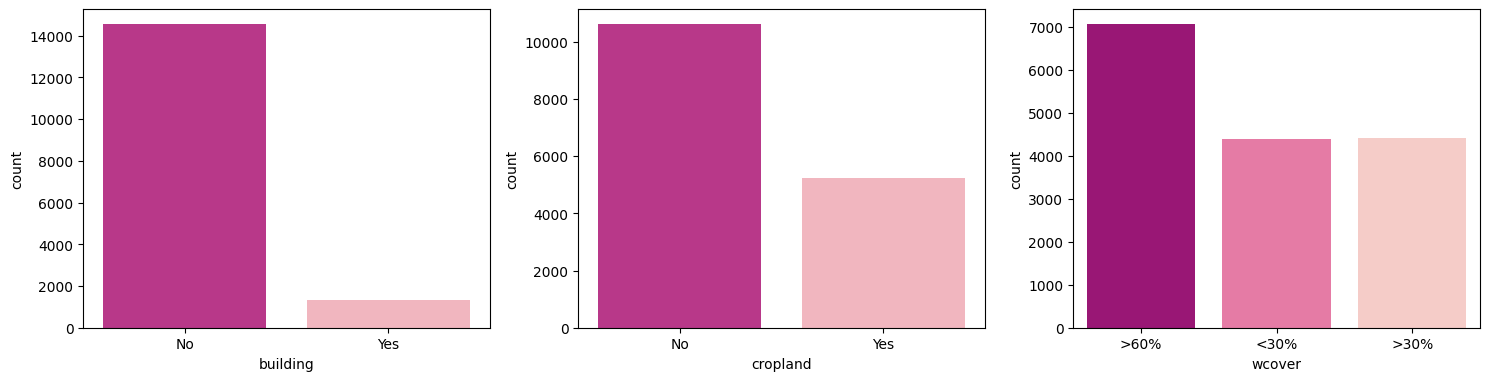

In [6]:
# ------------------------------------------------------------------
# COUNT PLOTS FOR VALUE DISTRIBUTION
# ------------------------------------------------------------------


def dist_list(df):
    plt.figure(figsize = (15, 60))
    
    # Hist Plots for each column by iteration
    for i, col in enumerate(df, 1):
        plt.subplot(16,3,i)
        sns.countplot(data = df, x = df[col],
                      hue = df[col],
                      palette = 'RdPu_r')
        # plt.title(f'{col}')
    
    # plt.suptitle('HISTOGRAM PLOTS')
    plt.tight_layout()
    plt.show()

dist_list(cats)

### Insights

1. The woody Vegetation contains Cover contains values for >60% as well as >30 nd <30. Later on this will be subset to only >60%
    The area is majorly >60% wood cover

2. Building and Crop land have 2 Classfications ; No and Yes
    The area has less building and crop land coverage

3. There are no NULL or EMPTY Rows in this Categorical data


### =======================================================================================================================================


### 1b. Numerical Columns

In [7]:
numerics = data_in.select_dtypes(include='number')
numerics.head(5)

,subid,lat,lon,bcount,x,y,bd20,bio1,bio12,bio7,...,mlon,nppm,npps,ph20,sirm,sirs,slope,snd20,soc20,tim
0,1548937,7.387687,-4.780390,0.0,-2.714375e+06,321874.969864,1.4900,262,1006,58,...,-4.781606,5052.299805,853.451416,6.100,0.717054,0.008259,0.729217,66.75,12.25,8.079082
1,1548936,8.690266,-5.770243,0.0,-2.812625e+06,474124.973063,1.2925,257,1118,70,...,-5.771476,5316.700195,933.074402,5.575,0.717198,0.007242,1.086981,51.50,14.25,9.549431
2,1548935,8.518763,-2.808147,0.0,-2.495125e+06,440374.986977,1.3050,265,930,66,...,-2.809363,4519.700195,1186.817627,5.850,0.717171,0.006744,1.159993,47.00,14.50,10.523131
3,1548934,8.637725,-3.048867,0.0,-2.520375e+06,454875.008083,1.3275,263,875,67,...,-3.050085,3439.800049,910.979309,5.950,0.718244,0.007917,2.471163,62.75,12.75,9.305363
4,1548933,7.993474,-6.044227,0.0,-2.846625e+06,396624.944149,1.4200,260,1073,60,...,-6.045455,5226.899902,802.602661,5.800,0.716653,0.007022,0.259416,55.00,13.25,15.732859


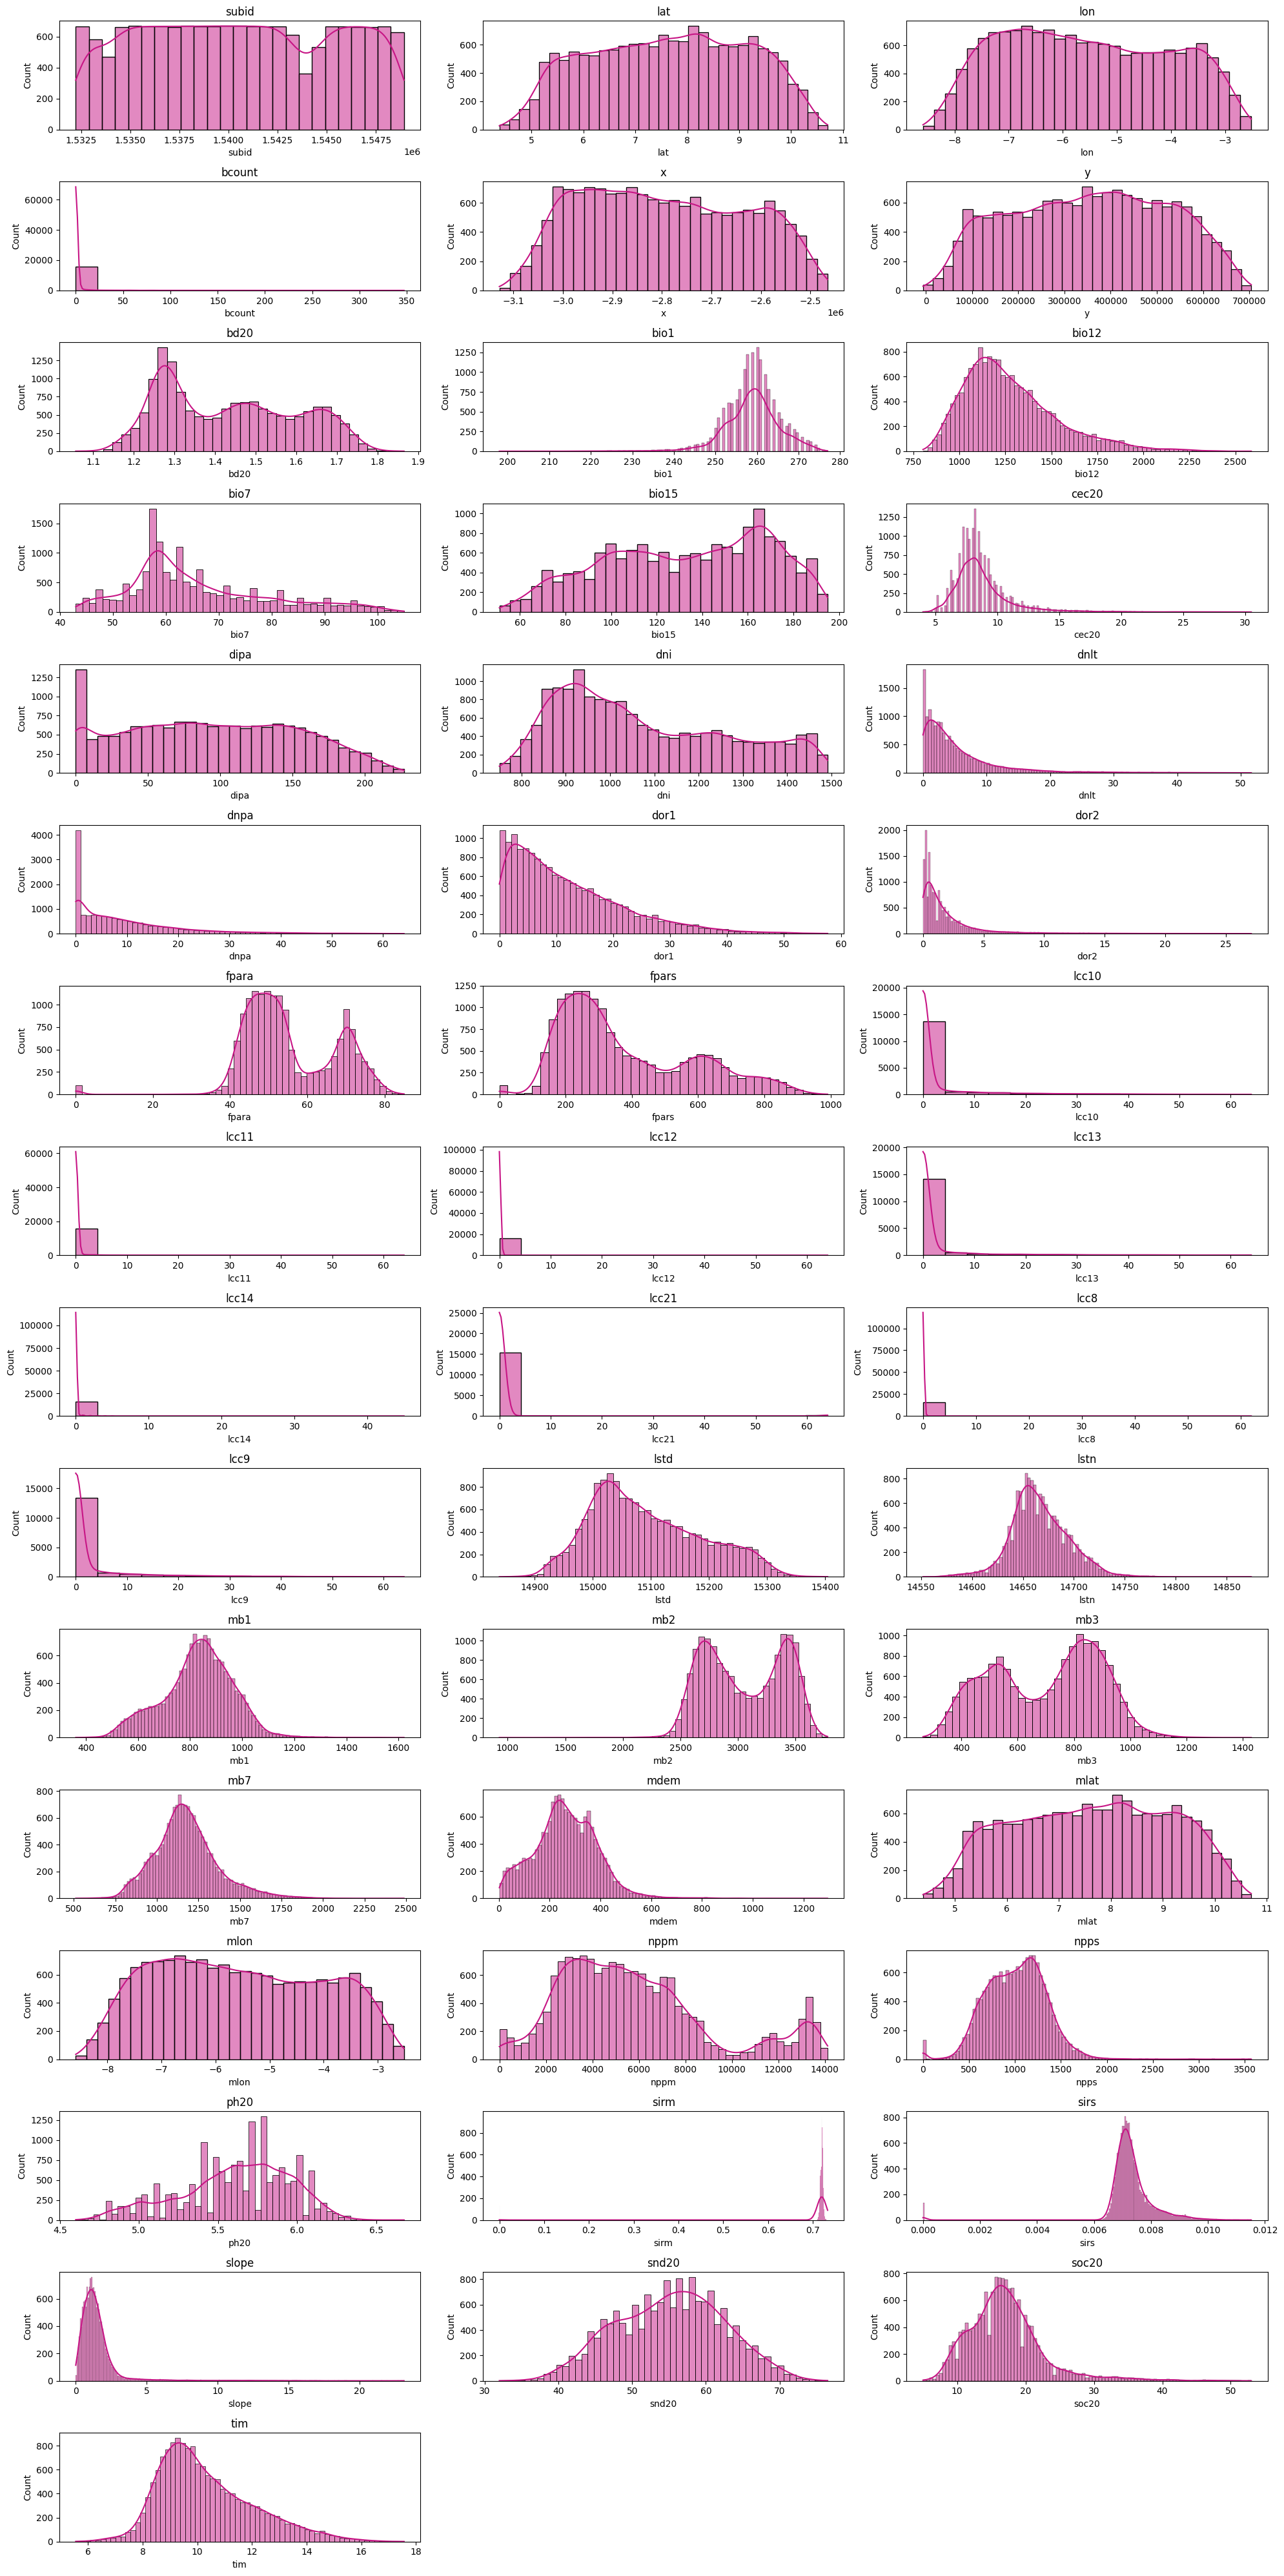

In [8]:
# ------------------------------------------------------------------
# HISTOGRAM PLOTS FOR NUMERICAL DISTRIBUTIONS
# ------------------------------------------------------------------


def dist_list(df):
    plt.figure(figsize = (20, 40))
    
    # Hist Plots for each column by iteration
    for i, col in enumerate(df, 1):
        plt.subplot(16,3,i)
        sns.histplot(data = df, x = df[col],
                     color = 'mediumvioletred',
                     kde = True)
        plt.title(f'{col}')

    
    plt.tight_layout()
    plt.show()

dist_list(numerics)

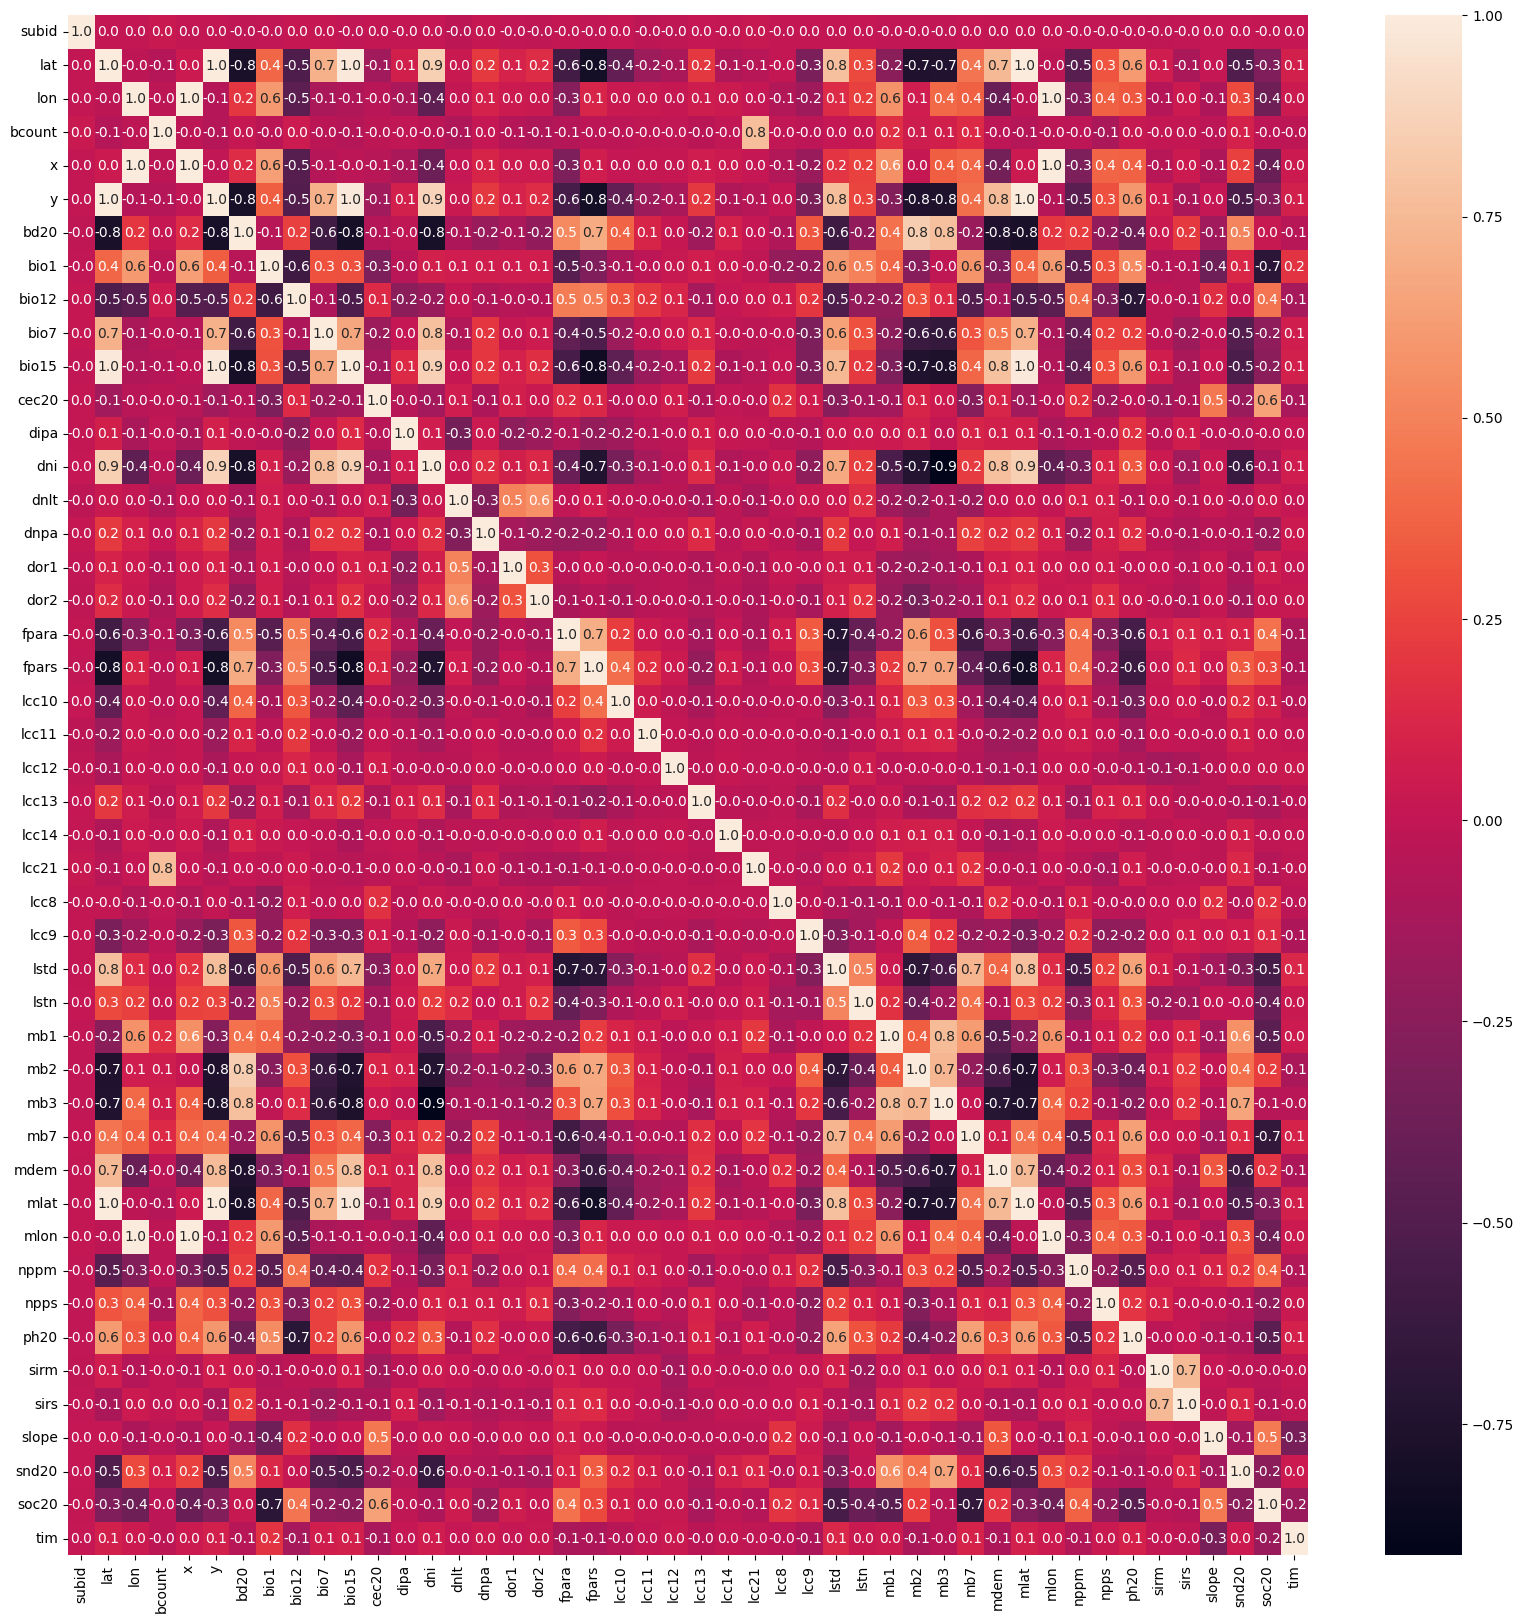

In [9]:
# ------------------------------------------------------------------
# CORRELOGRAM PLOT
# ------------------------------------------------------------------

plt.figure(figsize = (20, 20))
sns.heatmap(numerics.corr(),
            annot = True, fmt = '.1f')
plt.show()

## 2. DATA PROCESSING

### 2a. Handle Null Rows

In [10]:
# Extract Columns with Null values
nulls = numerics.isna().sum().to_frame(name='Nulls')
nulls_0 = nulls[nulls['Nulls'] > 0]
nulls_0.T

,bd20,cec20,lstd,lstn,mb1,mb2,mb3,mb7,ph20,snd20,soc20,tim
Nulls,45,45,19,19,1,1,1,1,45,45,45,1


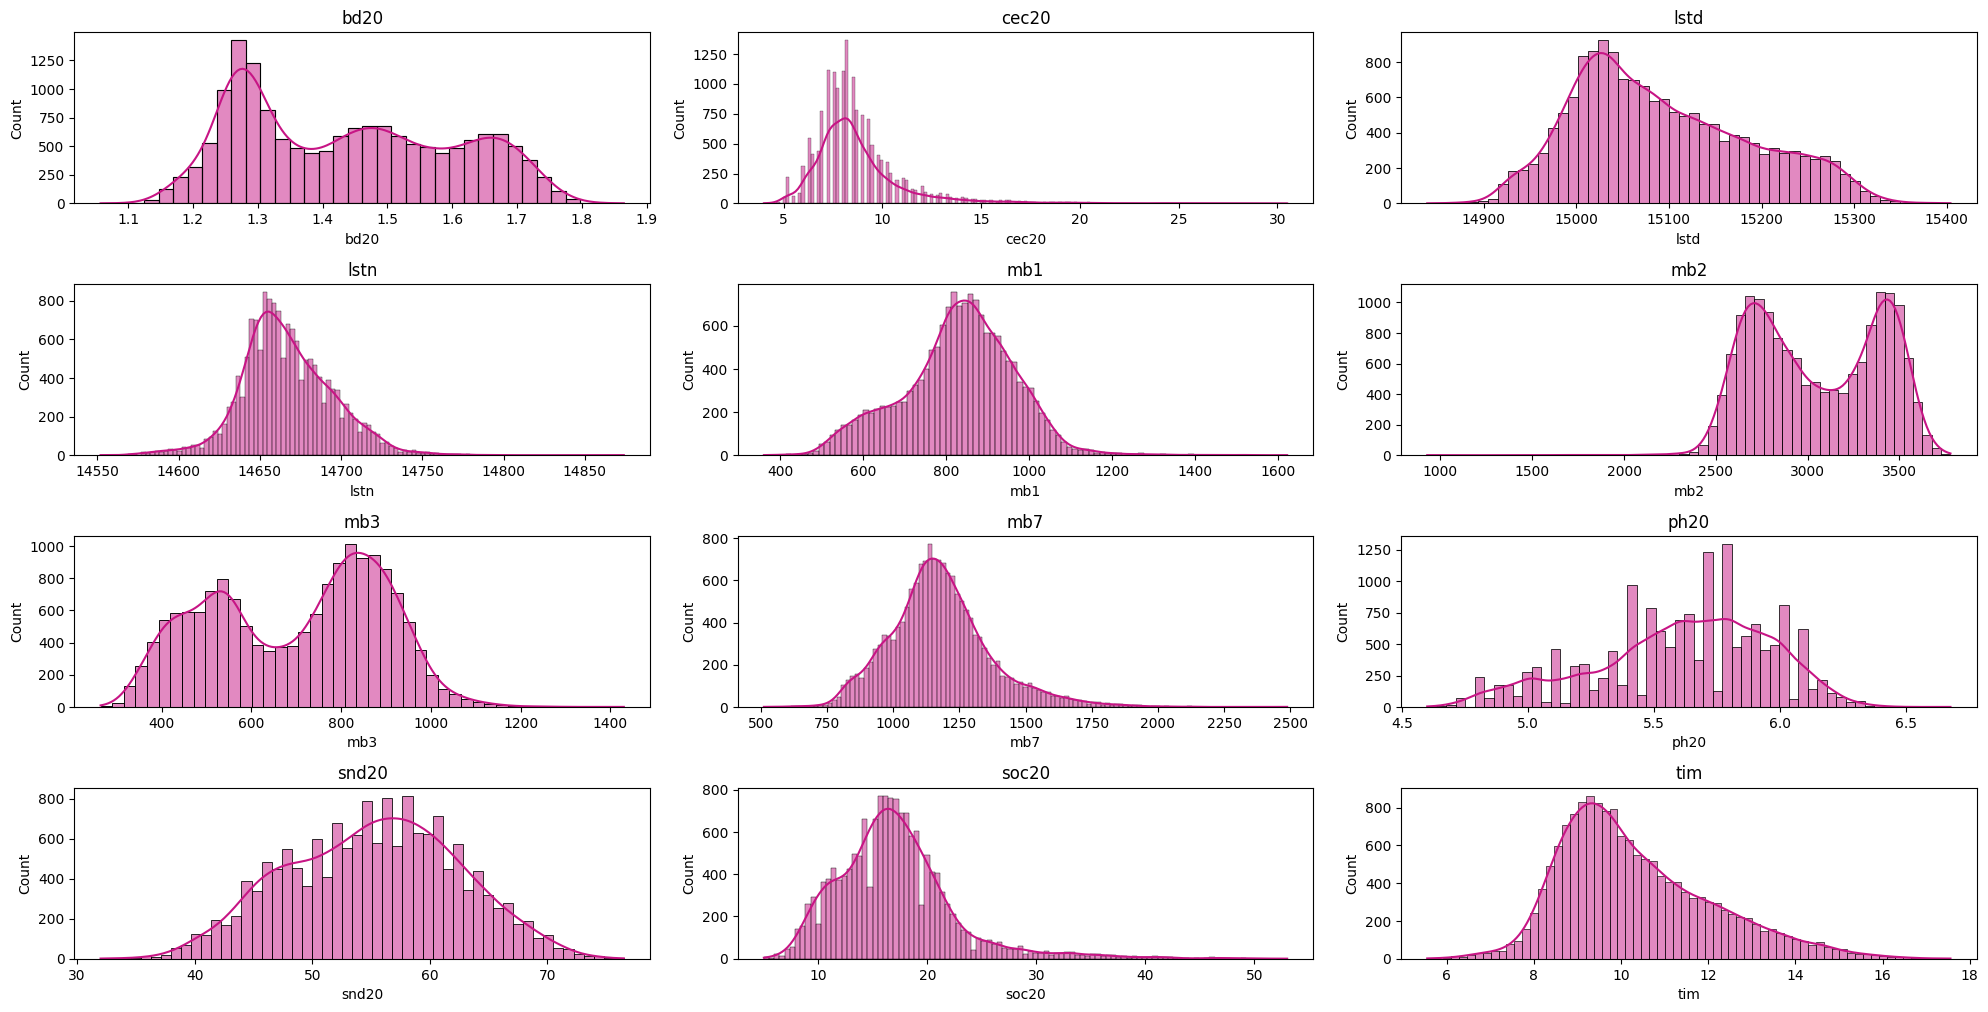

In [11]:
# EXPLORE THE DISTRIBUTION OF VALUES IN COLUMNS WITH NULLS

# Extract Null column names
null_cols = nulls_0.T.columns.values
def dist_list(df):
    plt.figure(figsize = (20, 40))
    
    # Hist Plots for each column by iteration
    for i, col in enumerate(df, 1):
        plt.subplot(16,3,i)
        sns.histplot(data = df, x = df[col],
                     color = 'mediumvioletred',
                     kde = True)
        plt.title(f'{col}')

    
    plt.tight_layout()
    plt.show()

dist_list(data_in[null_cols])

The Columns with Nulls have a Continuous, we can fill these null values by Interpolation intead of dropping them

In [ ]:
# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(data_in['lat'], data_in['lon'])]
gdf = gpd.GeoDataFrame(data_in, geometry=geometry, crs="EPSG:4326")

# Create a list of Columns with nulls
# col = nulls_0.T.columns.to_list()
# col.append('geometry')
empties = gdf[['geometry']]

# Drop NULLS in the original gdf
gdf = gdf.dropna(axis = 0)

# Perform spatial join to fill nulls with nearest Spatial neighbors
joined = gpd.sjoin_nearest(empties, gdf, how='inner')
# Drop Extra Columns
data_in_2 = joined
data_in_2 = data_in_2.drop(columns = ['index_right'])
data_in_2 = data_in_2.rename({'bd20_right': 'bd20'})

# print(data_in_2.isna().sum())

/home/allan/.local/lib/python3.11/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [13]:
# Check for Columns for columns with nulls
nulls2 = data_in_2.isna().sum().to_frame(name='Nulls')
nulls_1 = nulls2[nulls2['Nulls'] > 0]
nulls_1.T

""
Nulls


### 2b. Handle Duplicated Rows

In [14]:
print('Shape : ', data_in_2.shape)
print()
print('Duplicates : ', data_in_2.duplicated().sum())
print()

Shape :  (15856, 50)

Duplicates :  0



There are no Duplicated ROWS

### 2c. Categorical Columns Encoding

In [41]:
# Encode Categorical Columns
codes = data_in_2.copy()
encoder = OrdinalEncoder()
codes = encoder.fit_transform(codes[cats.columns])
codes = pd.DataFrame(codes, columns = ['encode_building', 'encode_cropland', 'encode_wcover'])

# Merge the 2dfs on index
data_in_3 = pd.concat([codes, data_in_2], axis = 1)
data_in_3 = pd.merge(left=data_in_2, right=codes, left_index=True, right_index=True, how='right' )
geo_data_in_3 = data_in_3.copy()
# Drop Geometry Column
data_in_3 = data_in_3.drop(columns = 'geometry')

# Confirm Shapes after Join
print('Codes', codes.shape)
print('Data 2', data_in_2.shape)
print('Data 3', data_in_3.shape)


Codes (15856, 3)
Data 2 (15856, 50)
Data 3 (15856, 52)


### 2d. Exploring Variable Relationships

What Varibles are higly correlated to Building occurance?

In [18]:
# Compute Correlation with building occurence
bld_corr = data_in_3.select_dtypes(include='number').corr()[['encode_wcover']]
bld_corr = bld_corr.sort_values(by = 'encode_wcover', ascending = False)
bld_corr.tail(3)

,encode_wcover
ph20,-0.383585
mb7,-0.400875
lstd,-0.435186


In [19]:
# Compute Correlation with cropland occurence
bld_corr = data_in_3.select_dtypes(include='number').corr()[['encode_cropland']]
bld_corr = bld_corr.sort_values(by = 'encode_cropland', ascending = False)
bld_corr.tail(5)

,encode_cropland
soc20,-0.152876
cec20,-0.153850
dor1,-0.168820
dor2,-0.178920
dnlt,-0.215894


### 2e. Numerical Columns Scaling

Use a MinMaxScaler to scale data to range 0 - 1

In [20]:
# Select Numeric Columns
data_in_4 = data_in_3[numerics.columns]
# Drop subid column
data_in_4 = data_in_4.drop(columns = 'subid')

# Create names for Scaled Columns
scaled_cols = []
for i in data_in_4.columns:
    i = 'scaled_'+i
    scaled_cols.append(i)
    
# Scale Numeric Columns
scaler = MinMaxScaler()
data_in_4 = scaler.fit_transform(data_in_4)
# Create a DF and merge DFs
data_in_4 = pd.DataFrame(data_in_4, columns = scaled_cols)
data_in_5 = pd.concat([codes, data_in_4], axis = 1)

# Confirm Shapes after Join
print('Codes', codes.shape)
print('Data 2', data_in_4.shape)
print('Data 3', data_in_5.shape)

Codes (15856, 3)
Data 2 (15856, 45)
Data 3 (15856, 48)


## 3. ML MODELLING

### 3a. Fill Gaps in test set

In [119]:
# Process Test Data and Fill Gaps
test_in = pd.read_csv(path_test)

# Prepare a Geodataframe
geometry_test = [Point(xy) for xy in zip(test_in['lat'], test_in['lon'])]
gdf_test = gpd.GeoDataFrame(test_in, geometry=geometry_test, crs="EPSG:4326")
gdf_test = gdf_test[['bcount', 'geometry', 'subid']]


# Perform spatial join to fill nulls with nearest Spatial neighbors
joined_test = gpd.sjoin_nearest(gdf_test, geo_data_in_3, how='inner')[['subid_left', 'bcount_right']]
joined_test = joined_test.rename(columns = {'subid_left' : 'subid', 'bcount_right' : 'bcount'})

# Post Join Cleaning
test_set = pd.merge(left = test_in, right = joined_test, on ='subid' , how='inner')
test_set = test_set.drop(columns = 'bcount_x')
test_set = test_set.rename(columns = {'bcount_y' : 'bcount'})

/home/allan/.local/lib/python3.11/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


### 3b. Train & Test Model

In [120]:
# Subset X and Y for Training
x_cols = ['encode_building', 'encode_cropland', 'encode_wcover']
y_train = data_in_5[x_cols]
x_train = data_in_5.drop(columns = x_cols)

In [121]:
# Fit Model
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

In [135]:
# PREPARE TEST DATA
x_test = test_set.drop(columns = 'subid')
# Scale Test Data
x_test_scaled = scaler.fit_transform(x_test)

# Create names for Scaled Columns as similar to train data
scaled_cols_test = []
for i in x_test.columns:
    i = 'scaled_'+i
    scaled_cols_test.append(i)

x_test = pd.DataFrame(x_test_scaled, columns = scaled_cols_test)

# Reorder columns as similar to train data
col_order = x_train.columns.to_list()
x_test = x_test[col_order]

In [136]:
y_pred = rf.predict(x_test)
y_pred = encoder.inverse_transform(y_pred)
y_pred = pd.DataFrame(y_pred, columns = ['building', 'cropland', 'wcover'])

# Merge the 2dfs on index
output = pd.concat([y_pred, test_in['subid']], axis = 1)

In [143]:
output.head(10)
output['wcover'].value_counts()

wcover
>60%    29
>30%     4
<30%     2
Name: count, dtype: int64

In [138]:
y_prob = rf.predict_proba(x_test)
building = pd.DataFrame(y_prob[0], columns = ['conf', 'inv_conf'])
building_prob = pd.concat([test_in['subid'], building], axis = 1)
building_prob[building_prob['subid'] == 1548905]

,subid,conf,inv_conf
0,1548905,0.93,0.07
